<a href="https://colab.research.google.com/github/Javcm/Deep-Learning/blob/main/Lots_of_fruits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import glob
import random
import gc
import matplotlib.pyplot as plt 
import seaborn as snb; snb.set()
#Model Libraries
from tensorflow.keras import Input,Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, Callback

#To connect with drive dolfers
from google.colab import drive 
from google.colab import files
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


La siguiente celda de código se utilizó para extraer las imágenes de prueba (X_train,y_train), entrenamiento (X_test,y_test) y de prueba externas al modelo (X_test_ext,y_test_ext), se observó que en Colab tarda demasiado la lectura por carpetas (más de dos  horas sin terminar), de modo que se hizo de forma local, se guardaron los numpy array, se subieron a la carpeta de drive donde se encuentran todos los datos asociados a este documento y se leyeron con Colab que tarda considerablemente menos.

También se modificó el archivo clasifiacación.csv, añadiéndo la clase acosiada a cada archivo según la nomenclatura manejada aquí. 

No se recomienda la ejecución de esta celda, pero se deja aquí el bloque de código.

In [ ]:
#Reading the files and creating the labels for the test data set
test_dir = "/content/gdrive/My Drive/T2 DL/Test"
X_test, count_labels, i = [], [], 0

for root, dirs, files in os.walk(test_dir):
    if i==0:
        names=dirs
    else:
        count_labels.append(len(files))
    i=i+1
    for y in glob.glob(os.path.join(root, '*.jpg')):
        img = cv2.imread(y) 
        RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        X_test.append(RGB_img) 
        
y_test=np.repeat(np.arange(len(count_labels)),count_labels, axis=0)

#Reading the files and creating the labels for the train data set
train_dir = "/content/gdrive/My Drive/T2 DL/Training"
X_train, count_labels, i = [], [], 0

for root, dirs, files in os.walk(train_dir):
    if i==0:
        names=dirs
    else:
        count_labels.append(len(files))
    i=i+1
    for y in glob.glob(os.path.join(root, '*.jpg')):
        img = cv2.imread(y) 
        RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        X_train.append(RGB_img) 
        
y_train=np.repeat(np.arange(len(count_labels)),count_labels, axis=0)

# #To save the completes train and test data
# X_train_all = X_train
# X_test_all = X_test
# y_train_all = y_train

#To complete the data frame classifiacion.csv to complete the labels
dict_names = dict(zip(names, np.arange(len(names))))
class_test=pd.read_csv('/content/gdrive/My Drive/T2 DL/clasificacion.csv',header=None)
aux=[]
for i in range(len(class_test)):   
    aux.append(dict_names[class_test[1][i]])
class_test["Class"]=aux
class_test.columns=["File","Fruit","Class"]

#Reading the external test files and creating the labels
test_dir = "/content/gdrive/My Drive/T2 DL/test/" 
test_path = os.path.join(test_dir,'*g')
files = glob.glob(test_path)
X_test_ext, y_test_ext = [], []
im_m=np.zeros((np.shape(files)[0],3))
for i,f1 in enumerate(files):
    img = cv2.imread(f1)
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #When using colab "/" must be used in the split, in windows use "\\" instead.
    y_test_ext.append(class_test[class_test["File"]==f1.split('/')[-1]]["Class"].values[0])
    X_test_ext.append(RGB_img)

#One hot encoding
y_test=pd.get_dummies(y_test)
y_train=pd.get_dummies(y_train)

#To check if the shapes matches
print(np.shape(X_train),np.shape(y_train),np.shape(X_test),np.shape(y_test),np.shape(X_test_ext),np.shape(y_test_ext))

In [2]:
#Reading the numpy arrays is faster for colab tha extracting the info for folders
X_train_all = np.load('/content/gdrive/My Drive/T2 DL/X_train.npy')
y_train_all = np.load('/content/gdrive/My Drive/T2 DL/y_train.npy')

X_test_all = np.load('/content/gdrive/My Drive/T2 DL/X_test.npy')
y_test_all = np.load('/content/gdrive/My Drive/T2 DL/y_test.npy')

X_test_ext = np.load('/content/gdrive/My Drive/T2 DL/X_test_ext.npy')
y_test_ext = np.load('/content/gdrive/My Drive/T2 DL/y_test_ext.npy')

class_test=pd.read_csv('/content/gdrive/My Drive/T2 DL/clasificacion.csv')
#To check if the shapes matches
print(np.shape(X_train),np.shape(y_train),np.shape(X_test),np.shape(y_test),np.shape(X_test_ext),np.shape(y_test_ext))

In [3]:
# To sample the data frames, because of memory troubles
random.seed(42)
n_sample_train = 15000
n_sample_test = 5000
train_sample = random.sample(range(0, len(X_train_all)), n_sample_train)
test_sample = random.sample(range(0, len(X_test_all)), n_sample_test)

X_test=X_test_all[test_sample,:,:,:]
del globals()["X_test_all"]
y_test=y_test_all[test_sample]
del globals()["y_test_all"]

X_train=X_train_all[train_sample,:,:,:]
del globals()["X_train_all"]
y_train=y_train_all[train_sample]
del globals()["y_train_all"]

#To check if the dimention matches
print(np.shape(X_train),np.shape(y_train),np.shape(X_test),np.shape(y_test))

##To save the numpy arrays, this little trick will help us later 
#np.save('X_train_sample', X_train)
#np.save('y_train_sample', y_train)
#np.save('X_test_sample', X_test)
#np.save('y_test_sample', y_test)

(15000, 100, 100, 3) (15000,) (5000, 100, 100, 3) (5000,)


In [16]:
#One hot encoding
y_test=pd.get_dummies(y_test)
y_train=pd.get_dummies(y_train)

#To check if the shapes matches
print(np.shape(X_train),np.shape(y_train),np.shape(X_test),np.shape(y_test),np.shape(X_test_ext),np.shape(y_test_ext))

(15000, 100, 100, 3) (15000, 131) (5000, 100, 100, 3) (5000, 131) (743, 100, 100, 3) (743,)


In [19]:
#To clear some Memory 
gc.collect()

# Neural Net of 3 
input_shape = Input(shape = (30000,))
x = Dense(1000, activation = "relu")(input_shape) 
x = Dense(1000, activation = "relu")(x)
x = Dense(1000, activation = "relu")(x)
x = Dense(1000, activation = "relu")(x) 
x = Dense(1000, activation = "relu")(x)
output = Dense(131, activation ="softmax")(x)

#se crea el modelo
model = Model(input_shape, output)
model.summary()


Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30000)]           0         
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              30001000  
_________________________________________________________________
dense_7 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_9 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_10 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_11 (Dense)             (None, 131)              


Como se muestra arriba, el modelo consta de un capa de salida, una de entrada y 4 capas ocultas 

Epoch 1/50
235/235 [==============================] - 59s 253ms/step - loss: 4.0380 - accuracy: 0.0979 - val_loss: 3.6372 - val_accuracy: 0.1122
Epoch 2/50
235/235 [==============================] - 59s 250ms/step - loss: 2.3495 - accuracy: 0.3457 - val_loss: 2.4429 - val_accuracy: 0.3634
Epoch 3/50
235/235 [==============================] - 59s 251ms/step - loss: 1.5142 - accuracy: 0.5553 - val_loss: 1.8408 - val_accuracy: 0.4874
Epoch 4/50
235/235 [==============================] - 59s 251ms/step - loss: 1.0054 - accuracy: 0.7090 - val_loss: 1.7727 - val_accuracy: 0.5328
Epoch 5/50
235/235 [==============================] - 59s 251ms/step - loss: 0.7141 - accuracy: 0.7918 - val_loss: 1.3788 - val_accuracy: 0.6280
Epoch 6/50
235/235 [==============================] - 59s 250ms/step - loss: 0.5568 - accuracy: 0.8523 - val_loss: 1.2080 - val_accuracy: 0.6564
Epoch 7/50
235/235 [==============================] - 59s 250ms/step - loss: 0.3847 - accuracy: 0.8965 - val_loss: 1.3262 - val_ac

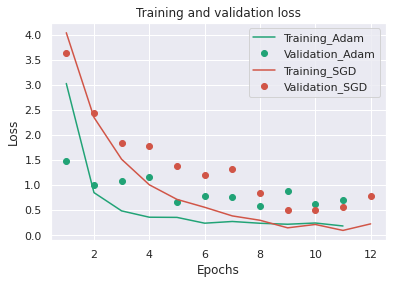

In [20]:
#To clear some Memory 
gc.collect()



#early stopping
callback = EarlyStopping(monitor='val_accuracy', patience=3)

#Callback to report time of training
from timeit import default_timer as timer
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)
cb = TimingCallback()


#First training is made with Adam optimizer
model1=model
model1.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model1.fit(X_train.reshape(len(X_train), 30000)/255, y_train, batch_size=64, epochs=50,
                    validation_data=(X_test.reshape(len(X_test), 30000)/255, y_test),callbacks=[callback,cb],verbose=1)
time1=sum(cb.logs)

#To clear some Memory 
gc.collect()

#Second training is made with SGD optimizer
model2=model
model2.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(X_train.reshape(len(X_train), 30000)/255, y_train, batch_size=64, epochs=50,
                    validation_data=(X_test.reshape(len(X_test), 30000)/255, y_test),callbacks=[callback,cb],verbose=1)


#To compare the training time
print("Total time of training Adam:",time1)
print("Total time of training SGD:",sum(cb.logs))

#Plotting the history losses
loss1,val_loss1 = history.history['loss'], history.history['val_loss']
epochs1 = range(1, len(loss1)+1)
loss2,val_loss2 = history2.history['loss'], history2.history['val_loss']
epochs2 = range(1, len(loss2)+1)
plt.plot(epochs1, loss1, 'b', label='Training_Adam',color="#21a376")
plt.plot(epochs1, val_loss1, 'bo', label='Validation_Adam',color="#21a376")
plt.plot(epochs2, loss2, 'b', label='Training_SGD',color="#d15547")
plt.plot(epochs2, val_loss2, 'bo', label='Validation_SGD',color="#d15547")
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.show()

weights1=np.array(model1.get_weights())
weights2=np.array(model2.get_weights())
np.save('weights1', weights1)
np.save('weights2', weights2)